# Análise de Redes - Componentes Curriculares da UFRN
## 📦 Sobre o Dataset
    
O conjunto de dados contém registros de empréstimos bibliotecários da UFRN com três arquivos principais:
1. `emprestimos.csv`: Registros de transações de empréstimos/devoluções
2. `exemplares.csv`: Informações sobre os exemplares físicos
3. `acervo-exemplares.csv`: Metadados sobre os itens do acervo (títulos, assuntos, ISBN)
Cada linha representa uma entidade específica com atributos como:
- Códigos de identificação (barras, sistema)
- Datas de transações
- Metadados de conteúdo (títulos, assuntos)
- Classificações de usuários (alunos, docentes, etc.)

## 🕸️ Nós e Arestas

**Nós (Livros):**
- Representados por `código de barras` único
- Atributos: Título completo, lista de assuntos

**Arestas (Transições):**
- Direcionadas (A → B)
- Indicam sequência temporal de empréstimos por mesmo usuário
- Atributos:
  - `weight`: Frequência da transição
  - `tipo`: Categoria do usuário (graduação, pós-graduação, etc.)
  - `color`: Codificação por tipo de vínculo

## ⚙️ Filtragem e Pipeline

**Pré-processamento:**
1. Limpeza de assuntos (remoção de caracteres especiais)
2. Merge dos datasets via chaves de relacionamento
3. Construção de sequências temporais por usuário

**Filtragem de Componentes:**
- Isolamento do maior componente fraco (12,346 nós)
- Justificativa: Foco nas conexões significativas

**Pipeline Analítico:**
1. Cálculo de métricas de rede (diâmetro, densidade)
2. Análise de distribuição de graus
3. Cálculo de coeficientes de clustering
4. Medição de assortatividade
5. Visualizações estratégicas

    

In [29]:
# Instalação de pacotes
!pip install pyvis community python-louvain python-igraph powerlaw networkx


# Importações
import os
import powerlaw
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import community as community_louvain
from tqdm import tqdm
import time
import random
import traceback
from collections import Counter
from pyvis.network import Network
import matplotlib.colors as mcolors
from google.colab import drive
from google.colab import files
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import math

In [7]:
# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

base_url = "https://raw.githubusercontent.com/minkyzecapagods/AR_acervo_ufrn/main/data/"

files_urls = {
    "emprestimos.csv": base_url + "emprestimos.csv",
    "exemplares.csv": base_url + "exemplares.csv",
    "acervo-exemplares.csv": base_url + "acervo-exemplares.csv"
}

# Funções auxiliares
def limpar_assunto(assunto):
    """Remove caracteres indesejados no final dos assuntos"""
    if not isinstance(assunto, str):
        return assunto
    chars_remover = ['.', '-', ';', ':', '!', '?', ' ']
    while assunto and assunto[-1] in chars_remover:
        assunto = assunto[:-1].strip()
    return assunto

def limpar_lista_assuntos(assuntos):
    """Aplica limpeza para todos os assuntos em uma lista"""
    return [limpar_assunto(a) for a in assuntos]

In [8]:
# Procurar arquivos no GitHub
print("\n=== CARREGANDO ARQUIVOS DO GITHUB ===")

try:
    # Carregar empréstimos
    emprestimos_df = pd.read_csv(
        files_urls["emprestimos.csv"],
        parse_dates=['data_emprestimo', 'data_devolucao'],
        sep=';',
        encoding='utf-8',
        dtype={'matricula_ou_siape': 'string', 'codigo_barras': 'string'}
    )
    print(f"emprestimos.csv carregado ({len(emprestimos_df)} registros)")

    # Carregar exemplares
    exemplares_df = pd.read_csv(
        files_urls["exemplares.csv"],
        sep=';',
        encoding='utf-8',
        dtype={'codigo_barras': 'string', 'registro_sistema': 'string'}
    )
    print(f"exemplares.csv carregado ({len(exemplares_df)} registros)")

    # Carregar acervo
    acervo_df = pd.read_csv(
        files_urls["acervo-exemplares.csv"],
        sep=';',
        encoding='utf-8',
        dtype={'registro_sistema': 'string', 'isbn': 'string'}
    )
    print(f"acervo-exemplares.csv carregado ({len(acervo_df)} registros)")

except Exception as e:
    print("Erro ao carregar os arquivos do GitHub:")
    print(e)


=== CARREGANDO ARQUIVOS DO GITHUB ===
emprestimos.csv carregado (35026 registros)
exemplares.csv carregado (616165 registros)
acervo-exemplares.csv carregado (256032 registros)


In [9]:
# Mesclar dados
print("\n=== MESCLANDO DADOS ===")
merged_df = pd.merge(
    emprestimos_df,
    exemplares_df,
    on='codigo_barras',
    how='left'
)

merged_df = pd.merge(
    merged_df,
    acervo_df,
    on='registro_sistema',
    how='left'
)

# Limpeza de dados
merged_df['assunto'] = merged_df['assunto'].fillna('Sem assunto').apply(limpar_assunto)
merged_df['titulo'] = merged_df['titulo'].fillna('Título desconhecido')
merged_df['sub_titulo'] = merged_df['sub_titulo'].fillna('')
merged_df['matricula_ou_siape'] = merged_df['matricula_ou_siape'].astype(str)

# Criar sequências de empréstimos por usuário
print("\n=== CRIANDO SEQUÊNCIAS DE EMPRÉSTIMOS ===")
sequencias = defaultdict(list)
merged_df = merged_df.sort_values(['matricula_ou_siape', 'data_emprestimo'])

for matricula, group in merged_df.groupby('matricula_ou_siape'):
    if len(group) > 1:
        livros = group['codigo_barras'].tolist()
        tipos = group['tipo_vinculo_usuario'].tolist()
        sequencias[matricula] = list(zip(livros, tipos))

print(f"Total de sequências criadas: {len(sequencias)}")


=== MESCLANDO DADOS ===

=== CRIANDO SEQUÊNCIAS DE EMPRÉSTIMOS ===
Total de sequências criadas: 7099


In [10]:
print("\n=== CONSTRUINDO GRAFO ===")
G = nx.DiGraph()

# Adicionar nós (livros)
livro_info = merged_df.drop_duplicates('codigo_barras')[['codigo_barras', 'titulo', 'sub_titulo', 'assunto']]
for _, row in livro_info.iterrows():
    assuntos = [limpar_assunto(a) for a in row['assunto'].split('#$&')] if pd.notna(row['assunto']) else ['Sem assunto']
    G.add_node(
        row['codigo_barras'],
        titulo=f"{row['titulo']} {row['sub_titulo']}",
        assuntos=assuntos
    )

# Adicionar arestas (transições entre empréstimos)
vinculo_cores = {
    'ALUNO DE GRADUAÇÃO': '#FF9AA2',
    'ALUNO DE PÓS-GRADUAÇÃO': '#B5B9FF',
    'ALUNO MÉDIO/TÉCNICO': '#97D8C4',
    'DOCENTE EXTERNO': '#89CFF0',
    'DISCENTE': '#B5EAD7',
    'SERVIDOR TÉCNICO-ADMINISTRATIVO': '#FFF0B5'
}

for user, seq in sequencias.items():
    for i in range(len(seq) - 1):
        livro_atual, _ = seq[i]
        livro_prox, tipo_prox = seq[i+1]
        if livro_atual in G.nodes and livro_prox in G.nodes:
            if G.has_edge(livro_atual, livro_prox):
                G[livro_atual][livro_prox]['weight'] += 1
            else:
                G.add_edge(
                    livro_atual,
                    livro_prox,
                    tipo=tipo_prox,
                    weight=1,
                    color=vinculo_cores.get(tipo_prox, '#888888')
                )

print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas")


=== CONSTRUINDO GRAFO ===
Grafo criado com 25189 nós e 24749 arestas


In [11]:
# Componentes conectados e densidade
print("\n=== COMPONENTES CONECTADOS E DENSIDADE ===")
if G.number_of_nodes() == 0:
    print("Grafo vazio - não é possível realizar análises")
else:
    # Componentes fracamente conectados
    weak_components = list(nx.weakly_connected_components(G))
    largest_weak = max(weak_components, key=len)
    G = G.subgraph(largest_weak)  # Trabalhar apenas com maior componente

    # Componentes fortemente conectados
    strong_components = list(nx.strongly_connected_components(G))
    largest_strong = max(strong_components, key=len)

    print(f"● Componentes fracamente conectados: {len(weak_components)}")
    print(f"● Maior componente fraco: {len(largest_weak)} nós")
    print(f"● Componentes fortemente conectados: {len(strong_components)}")
    print(f"● Maior componente forte: {len(largest_strong)} nós")
    print(f"● Densidade da rede: {nx.density(G):.6f}")
    print("\nInterpretação:")
    print("- Componentes fracos: Grupos de livros conectados ignorando direção")
    print("- Componentes fortes: Grupos onde empréstimos formam ciclos completos")
    print(f"- Densidade baixa ({nx.density(G):.4f}) indica rede esparsa")


=== COMPONENTES CONECTADOS E DENSIDADE ===
● Componentes fracamente conectados: 4366
● Maior componente fraco: 12346 nós
● Componentes fortemente conectados: 8017
● Maior componente forte: 3803 nós
● Densidade da rede: 0.000103

Interpretação:
- Componentes fracos: Grupos de livros conectados ignorando direção
- Componentes fortes: Grupos onde empréstimos formam ciclos completos
- Densidade baixa (0.0001) indica rede esparsa


In [12]:
# Matriz de adjacência (amostra)
print("\n=== MATRIZ DE ADJACÊNCIA (AMOSTRA) ===")
if G.number_of_nodes() > 5:
    top_nodes = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[:5]
    adj_matrix = nx.adjacency_matrix(G, nodelist=top_nodes).todense()
    print("Amostra da matriz (top 5 livros por grau):")
    print(adj_matrix)
    print("\nInterpretação:")
    print("- Cada linha/coluna representa um livro")
    print("- Valor 1 indica empréstimo sequencial entre os livros")
    print("- Matriz esparsa reflete baixa densidade da rede")
else:
    print("Grafo muito pequeno para mostrar matriz")


=== MATRIZ DE ADJACÊNCIA (AMOSTRA) ===
Amostra da matriz (top 5 livros por grau):
[[0 1 0 1 0]
 [2 0 0 1 1]
 [0 0 0 0 0]
 [1 0 0 0 2]
 [1 1 0 0 0]]

Interpretação:
- Cada linha/coluna representa um livro
- Valor 1 indica empréstimo sequencial entre os livros
- Matriz esparsa reflete baixa densidade da rede


In [13]:
# Diâmetro e periferia
print("\n=== DIÂMETRO E PERIFERIA ===")
if G.number_of_nodes() == 0:
    print("Grafo vazio - não é possível calcular")
else:
    try:
        # Converter NetworkX → igraph
        edge_list = [(u, v) for u, v in G.edges()]
        g_ig = ig.Graph.TupleList(edge_list, directed=True)

        # Mapeamento de índices para rótulos
        node_labels = {i: label for i, label in enumerate(g_ig.vs['name'])}

        # 1. Análise para grafo direcionado (considerando componentes fracamente conectados)
        print("\n[ANÁLISE PARA GRAFO DIRECIONADO]")
        print("(Considerando componentes fracamente conectados)")

        # Obter maior componente fracamente conectado
        weak_components = g_ig.components(mode='WEAK')
        largest_weak = weak_components.giant()

        # Calcular excentricidade no maior componente fraco
        weak_eccentricities = largest_weak.eccentricity()
        weak_diameter = max(weak_eccentricities)
        weak_periphery = [i for i, ecc in enumerate(weak_eccentricities) if ecc == weak_diameter]

        print(f"● Diâmetro: {weak_diameter}")
        print(f"● Nós periféricos: {len(weak_periphery)} livros")

        # Exibir exemplos de periferia
        print("\nExemplo de livros periféricos (direcionado):")
        for node_idx in weak_periphery[:3]:
            nx_node = largest_weak.vs[node_idx]['name']
            title = G.nodes[nx_node].get('titulo', 'Sem título')[:50]
            sub_title = G.nodes[nx_node].get('sub_titulo', '')
            full_title = (title + sub_title)
            print(f"- {full_title} (ID: {nx_node})")

        # 2. Análise para grafo não direcionado
        print("\n[ANÁLISE PARA GRAFO NÃO DIRECIONADO]")
        print("(Convertido para não direcionado)")

        # Criar versão não direcionada
        undir_ig = g_ig.as_undirected()

        # Obter maior componente conectado
        undir_components = undir_ig.components(mode='WEAK')
        largest_undir = undir_components.giant()

        # Calcular excentricidade
        undir_eccentricities = largest_undir.eccentricity()
        undir_diameter = max(undir_eccentricities)
        undir_periphery = [i for i, ecc in enumerate(undir_eccentricities) if ecc == undir_diameter]

        print(f"● Diâmetro: {undir_diameter}")
        print(f"● Nós periféricos: {len(undir_periphery)} livros")

        # Exibir exemplos de periferia
        print("\nExemplo de livros periféricos (não direcionado):")
        for node_idx in undir_periphery[:3]:
            nx_node = largest_undir.vs[node_idx]['name']
            title = G.nodes[nx_node].get('titulo', 'Sem título')[:50]
            sub_title = G.nodes[nx_node].get('sub_titulo', '')
            full_title = (title + sub_title)
            print(f"- {full_title} (ID: {nx_node})")

        # 3. Comparação entre as abordagens
        print("\n[COMPARAÇÃO]")
        print(f"Diferença no diâmetro: {abs(weak_diameter - undir_diameter)}")
        print(f"Diferença na periferia: {abs(len(weak_periphery) - len(undir_periphery))} nós")
        print("\nInterpretação:")
        print("- Grafo direcionado: Considera a direção das arestas (empréstimos sequenciais)")
        print("- Grafo não direcionado: Ignora direção, considera apenas conexões")
        print("- Em redes de biblioteca, diferenças significativas podem indicar padrões direcionais fortes")
    except nx.NetworkXError as e:
        print(f"Erro no cálculo: {e}")
        print("Provavelmente devido a componentes desconectados")


=== DIÂMETRO E PERIFERIA ===

[ANÁLISE PARA GRAFO DIRECIONADO]
(Considerando componentes fracamente conectados)
● Diâmetro: 127.0
● Nós periféricos: 1 livros

Exemplo de livros periféricos (direcionado):
- Romeu e Julieta /  (ID: 2013010138)

[ANÁLISE PARA GRAFO NÃO DIRECIONADO]
(Convertido para não direcionado)
● Diâmetro: 105.0
● Nós periféricos: 2 livros

Exemplo de livros periféricos (não direcionado):
- Computer graphics : principles and practice / (ID: 2014066050)
- Romeu e Julieta /  (ID: 2013010138)

[COMPARAÇÃO]
Diferença no diâmetro: 22.0
Diferença na periferia: 1 nós

Interpretação:
- Grafo direcionado: Considera a direção das arestas (empréstimos sequenciais)
- Grafo não direcionado: Ignora direção, considera apenas conexões
- Em redes de biblioteca, diferenças significativas podem indicar padrões direcionais fortes



=== DISTRIBUIÇÃO DE GRAU ===


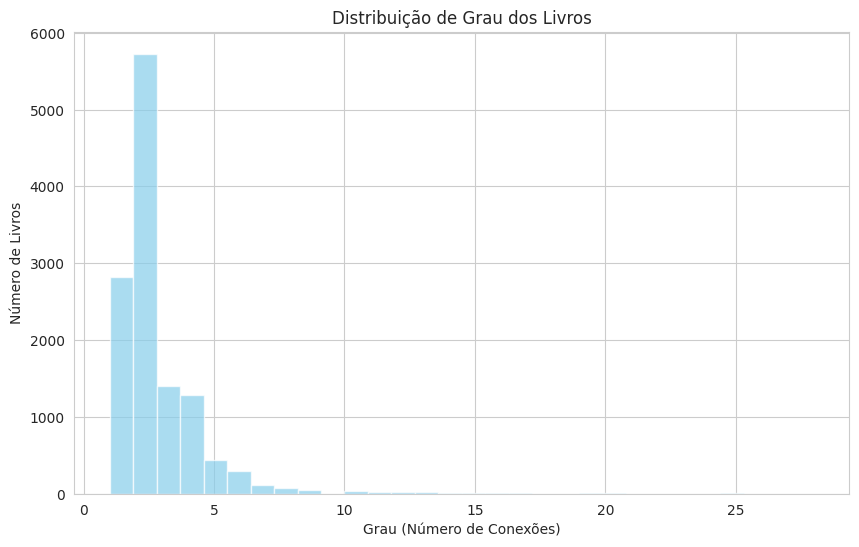

Interpretação:
- Distribuição típica de redes scale-free: poucos hubs, muitos nós periféricos
- Cauda longa indica livros populares com muitas conexões


In [14]:
# Distribuição de grau
print("\n=== DISTRIBUIÇÃO DE GRAU ===")
if G.number_of_nodes() > 0:
    degrees = [d for _, d in G.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, alpha=0.7, color='skyblue')
    plt.title('Distribuição de Grau dos Livros')
    plt.xlabel('Grau (Número de Conexões)')
    plt.ylabel('Número de Livros')
    plt.grid(True)
    plt.show()

    print("Interpretação:")
    print("- Distribuição típica de redes scale-free: poucos hubs, muitos nós periféricos")
    print("- Cauda longa indica livros populares com muitas conexões")
else:
    print("Grafo vazio - não é possível gerar histograma")

In [15]:
# Coeficientes de clustering
print("\n=== COEFICIENTES DE CLUSTERING ===")
if G.number_of_nodes() > 0:
    # Clustering global
    clustering_global = nx.average_clustering(G)
    print(f"● Coeficiente de clustering global: {clustering_global:.4f}")

    # Clustering local para nós importantes
    print("\nClustering local para nós centrais:")

    # Calcula o betweenness (não normalizado) com igraph
    betweenness_raw = g_ig.betweenness()

    # Normaliza o betweenness:
    # Fórmula: dividir por ((n-1)*(n-2)) pois o grafo é direcionado
    n_nodes = g_ig.vcount()
    norm_factor = (n_nodes - 1) * (n_nodes - 2)
    betweenness_norm = [b / norm_factor for b in betweenness_raw]

    # Mapear para os IDs do NetworkX
    btw_dict = {list(G.nodes)[i]: score for i, score in enumerate(betweenness_norm)}

    # Selecionar os 3 nós com maior betweenness
    top_nodes = sorted(btw_dict.items(), key=lambda x: x[1], reverse=True)[:3]

    # Printar resultados
    for node, score in top_nodes:
        clustering_local = nx.clustering(G, node)
        title = G.nodes[node].get('titulo', 'Sem titulo')
        sub_title = G.nodes[node].get('sub_titulo', '')
        full_title = (title + sub_title)
        print(f"- {title}:")
        print(f"  Betweenness (normalizado): {score:.6f}, Clustering: {clustering_local:.4f}")


    print("\nInterpretação:")
    print("- Clustering global mede tendência de formação de triângulos")
    print(f"- Valor {clustering_global:.4f} indica baixa transitividade na rede")
    print("- Clustering local baixo em nós centrais sugere estrutura em estrela")
else:
    print("Grafo vazio - não é possível calcular")


=== COEFICIENTES DE CLUSTERING ===
● Coeficiente de clustering global: 0.0086

Clustering local para nós centrais:
- O nascimento de uma flor / :
  Betweenness (normalizado): 0.089530, Clustering: 0.0000
- O menino grapiúna / :
  Betweenness (normalizado): 0.084884, Clustering: 0.0000
- Homo ludens : o jogo como elemento da cultura /:
  Betweenness (normalizado): 0.046564, Clustering: 0.0000

Interpretação:
- Clustering global mede tendência de formação de triângulos
- Valor 0.0086 indica baixa transitividade na rede
- Clustering local baixo em nós centrais sugere estrutura em estrela



=== ASSORTATIVIDADE ===
● Assortatividade por grau: 0.4556

Calculando assortatividade por assunto...
● Similaridade média de assuntos: 0.1707
● Assortatividade máxima ponderada: 0.4120
● Diversidade temática global: 0.8066

● Top 5 assuntos mais centrais (influência estrutural):
(Mede quão importante o assunto é para a conectividade da rede)
- Literatura infantojuvenil: 1.0000
- Brasil: 0.3749
- História: 0.3072
- Matemática: 0.2690
- Cálculo: 0.2607

Interpretação:
- Assortatividade por grau (0.4556): Livros populares conectam-se com outros populares
- Similaridade de assuntos (0.1707): Empréstimos ocorrem entre assuntos diversos
- Diversidade temática (0.8066): Alta interdisciplinaridade nas conexões


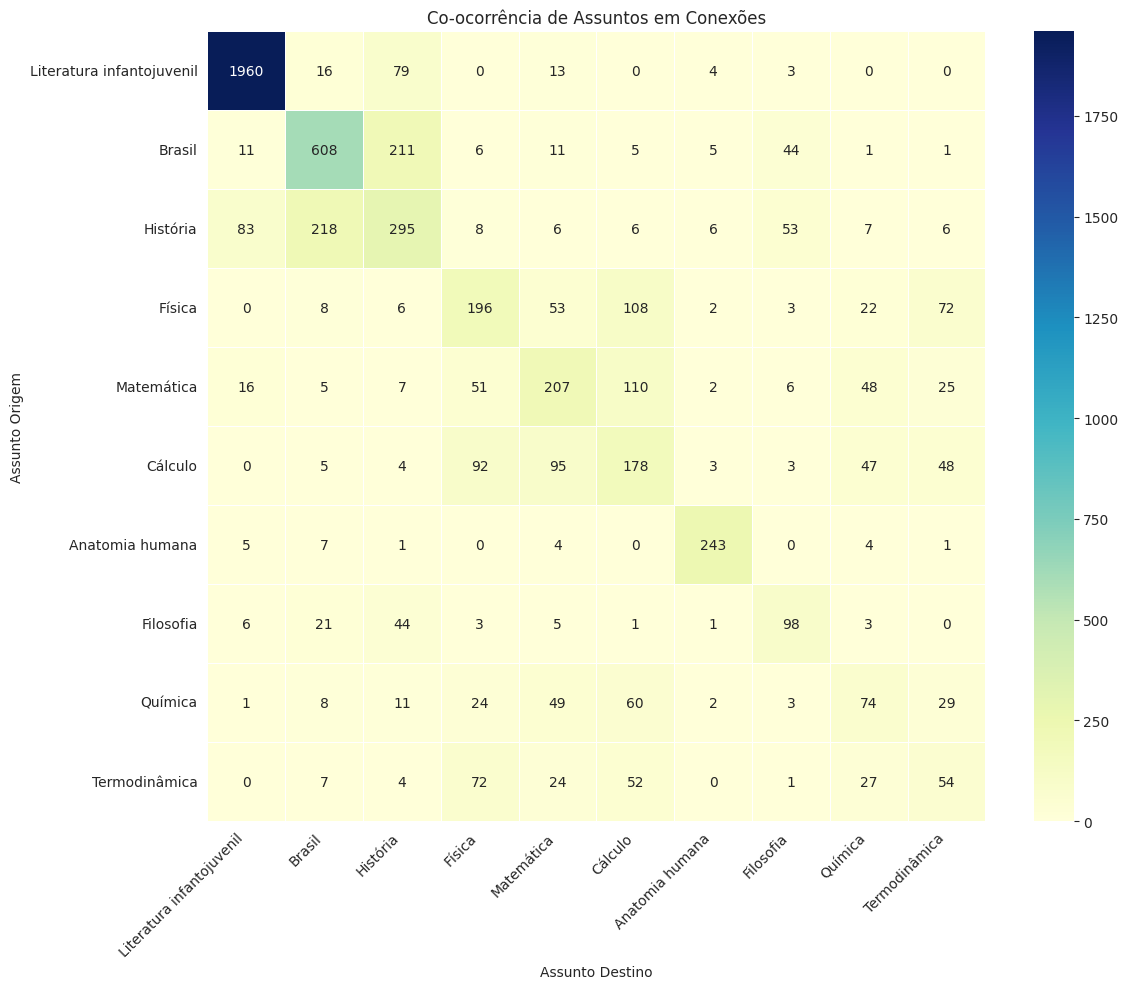


● Variedade de Conexões (dentre os 10 assuntos principais):
(Mede com quantos outros assuntos diferentes cada assunto se conecta)
- Brasil: 1.000 (conectado com 100.0% dos outros assuntos)
- História: 1.000 (conectado com 100.0% dos outros assuntos)
- Matemática: 1.000 (conectado com 100.0% dos outros assuntos)
- Química: 1.000 (conectado com 100.0% dos outros assuntos)
- Física: 0.889 (conectado com 88.9% dos outros assuntos)
- Cálculo: 0.889 (conectado com 88.9% dos outros assuntos)
- Filosofia: 0.889 (conectado com 88.9% dos outros assuntos)
- Termodinâmica: 0.778 (conectado com 77.8% dos outros assuntos)
- Anatomia humana: 0.667 (conectado com 66.7% dos outros assuntos)
- Literatura infantojuvenil: 0.556 (conectado com 55.6% dos outros assuntos)

● Comparação entre Influência e Variedade:
Assunto			Influência	Variedade
Literatura infa	1.0000		0.5556
Brasil	0.3749		1.0000
História	0.3072		1.0000
Física	0.2507		0.8889
Matemática	0.2690		1.0000
Cálculo	0.2607		0.8889
Anatomia humana	

In [16]:
# Assortatividade
print("\n=== ASSORTATIVIDADE ===")
if G.number_of_nodes() > 0:
    # 1. Assortatividade geral (por grau)
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    print(f"● Assortatividade por grau: {degree_assortativity:.4f}")

    # 2. Assortatividade por assunto (análise completa)
    print("\nCalculando assortatividade por assunto...")

    # Definir função expandida com tratamento de erros robusto
    def calcular_assortatividade_multiplos_assuntos(G):
        """Calcula a assortatividade considerando todos os assuntos de cada livro"""
        try:
            # Verificar se há arestas
            if G.number_of_edges() == 0:
                print("Aviso: Grafo sem arestas - não é possível calcular métricas de assunto")
                return None

            total_similaridade = 0
            count = 0

            # Similaridade média
            for u, v in G.edges():
                assuntos_u = set(G.nodes[u].get('assuntos', ['Sem assunto']))
                assuntos_v = set(G.nodes[v].get('assuntos', ['Sem assunto']))

                # Evitar divisão por zero
                union = len(assuntos_u | assuntos_v)
                if union == 0:
                    similaridade = 0
                else:
                    intersection = len(assuntos_u & assuntos_v)
                    similaridade = intersection / union

                total_similaridade += similaridade
                count += 1

            similaridade_media = total_similaridade / count if count > 0 else 0

            # Matriz de co-ocorrência
            coocorrencia = defaultdict(lambda: defaultdict(int))
            for u, v in G.edges():
                assuntos_u = G.nodes[u].get('assuntos', ['Sem assunto'])
                assuntos_v = G.nodes[v].get('assuntos', ['Sem assunto'])

                for assunto_u in assuntos_u:
                    for assunto_v in assuntos_v:
                        coocorrencia[assunto_u][assunto_v] += 1

            # Assortatividade máxima
            assort_max = 0
            for u, v in G.edges():
                assuntos_u = set(G.nodes[u].get('assuntos', ['Sem assunto']))
                assuntos_v = set(G.nodes[v].get('assuntos', ['Sem assunto']))

                max_similarity = 0
                for assunto_u in assuntos_u:
                    for assunto_v in assuntos_v:
                        if assunto_u == assunto_v:
                            similarity = 1
                        else:
                            total_cooc = sum(coocorrencia[assunto_u].values())
                            # Prevenir divisão por zero
                            similarity = coocorrencia[assunto_u][assunto_v] / total_cooc if total_cooc > 0 else 0

                        if similarity > max_similarity:
                            max_similarity = similarity

                assort_max += max_similarity

            assort_max /= count if count > 0 else 1

            # Diversidade temática
            diversidade_global = 0
            valid_nodes = 0  # Contar nós com vizinhos válidos

            for node in G.nodes():
                assuntos_node = set(G.nodes[node].get('assuntos', ['Sem assunto']))
                vizinhos = list(G.neighbors(node))

                if not vizinhos:
                    continue

                diversidade_node = 0
                valid_vizinhos = 0

                for vizinho in vizinhos:
                    assuntos_vizinho = set(G.nodes[vizinho].get('assuntos', ['Sem assunto']))

                    if not assuntos_vizinho:  # Evitar conjuntos vazios
                        continue

                    # Calcular proporção de novos assuntos
                    novos_assuntos = len(assuntos_vizinho - assuntos_node)
                    diversidade_node += novos_assuntos / len(assuntos_vizinho)
                    valid_vizinhos += 1

                if valid_vizinhos > 0:
                    diversidade_global += diversidade_node / valid_vizinhos
                    valid_nodes += 1

            # Calcular diversidade global apenas se houver nós válidos
            if valid_nodes > 0:
                diversidade_global /= valid_nodes
            else:
                diversidade_global = 0

            # Centralidade de assuntos
            assunto_centralidade = defaultdict(float)
            for node in G.nodes():
                # Usar degree centrality como fallback se betweenness não existir
                centrality = G.nodes[node].get('betweenness_centrality', G.degree(node))
                for assunto in G.nodes[node].get('assuntos', []):
                    assunto_centralidade[assunto] += centrality

            # Normalizar
            max_centralidade = max(assunto_centralidade.values(), default=1)
            if max_centralidade == 0:
                max_centralidade = 1  # Evitar divisão por zero
            assunto_centralidade = {k: v/max_centralidade for k, v in assunto_centralidade.items()}

            return {
                'similaridade_media': similaridade_media,
                'assort_max': assort_max,
                'diversidade_global': diversidade_global,
                'assunto_centralidade': assunto_centralidade,
                'matriz_coocorrencia': coocorrencia
            }

        except Exception as e:
            print(f"Erro detalhado no cálculo de assortatividade: {str(e)}")
            traceback.print_exc()
            return None

    # Calcular métricas expandidas
    resultado_assort = calcular_assortatividade_multiplos_assuntos(G)

    if resultado_assort:
        print(f"● Similaridade média de assuntos: {resultado_assort['similaridade_media']:.4f}")
        print(f"● Assortatividade máxima ponderada: {resultado_assort['assort_max']:.4f}")
        print(f"● Diversidade temática global: {resultado_assort['diversidade_global']:.4f}")

        # Top assuntos mais centrais (INFLUÊNCIA)
        if resultado_assort['assunto_centralidade']:
            top_assuntos_centrais = sorted(
                resultado_assort['assunto_centralidade'].items(),
                key=lambda x: x[1],
                reverse=True
            )[:5]

            print("\n● Top 5 assuntos mais centrais (influência estrutural):")
            print("(Mede quão importante o assunto é para a conectividade da rede)")
            for assunto, score in top_assuntos_centrais:
                print(f"- {assunto}: {score:.4f}")
        else:
            print("\nNenhum assunto encontrado para cálculo de centralidade")

        # Interpretação combinada
        print("\nInterpretação:")
        print(f"- Assortatividade por grau ({degree_assortativity:.4f}): ", end="")
        if degree_assortativity > 0:
            print("Livros populares conectam-se com outros populares")
        else:
            print("Livros populares conectam-se com livros menos conhecidos")

        if 'similaridade_media' in resultado_assort:
            print(f"- Similaridade de assuntos ({resultado_assort['similaridade_media']:.4f}): ", end="")
            if resultado_assort['similaridade_media'] > 0.5:
                print("Forte tendência de empréstimos dentro do mesmo assunto")
            else:
                print("Empréstimos ocorrem entre assuntos diversos")

        if 'diversidade_global' in resultado_assort:
            print(f"- Diversidade temática ({resultado_assort['diversidade_global']:.4f}): ", end="")
            if resultado_assort['diversidade_global'] > 0.6:
                print("Alta interdisciplinaridade nas conexões")
            elif resultado_assort['diversidade_global'] < 0.4:
                print("Baixa interdisciplinaridade (conexões dentro do mesmo assunto)")
            else:
                print("Padrão misto de conexões")

        # Visualizar matriz de co-ocorrência para assuntos principais

        # Encontrar assuntos mais comuns
        todos_assuntos = []
        for n in G.nodes:
            todos_assuntos.extend(G.nodes[n].get('assuntos', []))
        top_assuntos_comuns = [a for a, _ in Counter(todos_assuntos).most_common(10)]

        # Construir matriz reduzida
        matriz = []
        for assunto_origem in top_assuntos_comuns:
            linha = []
            for assunto_destino in top_assuntos_comuns:
                linha.append(resultado_assort['matriz_coocorrencia'][assunto_origem].get(assunto_destino, 0))
            matriz.append(linha)

        # Criar heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            matriz,
            annot=True,
            fmt="d",
            cmap="YlGnBu",
            xticklabels=top_assuntos_comuns,
            yticklabels=top_assuntos_comuns,
            linewidths=0.5
        )
        plt.title("Co-ocorrência de Assuntos em Conexões")
        plt.xlabel("Assunto Destino")
        plt.ylabel("Assunto Origem")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # DIVERSIDADE DE CONEXÕES (VARIEDADE)
        assunto_variedade = {}
        total_assuntos = len(top_assuntos_comuns)

        for assunto in top_assuntos_comuns:
            # Contar com quantos outros assuntos diferentes se conecta
            outros_assuntos = [a for a in top_assuntos_comuns if a != assunto]
            conexoes_com_outros = sum(1 for a in outros_assuntos
                                     if resultado_assort['matriz_coocorrencia'][assunto].get(a, 0) > 0)

            # Calcular variedade (proporção de outros assuntos conectados)
            variedade = conexoes_com_outros / (total_assuntos - 1) if total_assuntos > 1 else 0
            assunto_variedade[assunto] = variedade

        print("\n● Variedade de Conexões (dentre os 10 assuntos principais):")
        print("(Mede com quantos outros assuntos diferentes cada assunto se conecta)")
        for assunto, variedade in sorted(assunto_variedade.items(), key=lambda x: x[1], reverse=True):
            print(f"- {assunto[:30]}: {variedade:.3f} (conectado com {variedade*100:.1f}% dos outros assuntos)")

        # COMPARAÇÃO ENTRE AS MÉTRICAS
        print("\n● Comparação entre Influência e Variedade:")
        print("Assunto\t\t\tInfluência\tVariedade")
        for assunto in top_assuntos_comuns:
            influencia = resultado_assort['assunto_centralidade'].get(assunto, 0)
            variedade = assunto_variedade.get(assunto, 0)
            print(f"{assunto[:15]}\t{influencia:.4f}\t\t{variedade:.4f}")

    else:
        print("❌ Não foi possível calcular métricas de assunto")
else:
    print("Grafo vazio - não é possível calcular")

In [17]:
print("\n=== CÁLCULO DE CENTRALIDADES ===")
if G.number_of_nodes() > 0:
    print("Calculando métricas usando igraph...")

    # 1. Garantir que temos o objeto igraph
    if 'g_ig' not in locals():
        # Converter se necessário
        edge_list = [(u, v) for u, v in G.edges()]
        g_ig = ig.Graph.TupleList(edge_list, directed=True, vertex_name_attr="name")

    n = g_ig.vcount()

    # 2. Calcular todas as centralidades com igraph (mais eficiente)
    # Degree centrality
    degrees = g_ig.degree()
    max_degree = max(degrees) if degrees else 1
    degree_centrality = [d/max_degree for d in degrees]  # Normalização simples

    # Betweenness centrality (correto para direcionado)
    betweenness_raw = g_ig.betweenness(directed=True)
    max_btw = (n-1)*(n-2)  # Normalização para grafos DIRECIONADOS
    betweenness_centrality = [b/max_btw for b in betweenness_raw] if max_btw > 0 else [0]*n

    # Closeness centrality com tratamento para desconexão
    def safe_closeness(g):
        closeness = []
        for v in g.vs:
            try:
                # Considerar apenas caminhos de saída (mais relevante)
                c = g.closeness(v.index, mode="OUT", normalized=True)
                closeness.append(c)
            except:
                closeness.append(0)
        return closeness

    closeness_centrality = safe_closeness(g_ig)

    # Eigenvector centrality
    try:
        eigenvector_centrality = g_ig.eigenvector_centrality(directed=True, scale=True)
    except:
        # Fallback para Pagerank
        eigenvector_centrality = g_ig.pagerank(directed=True)

    # 3. Mapear para NetworkX usando nomes
    node_names = g_ig.vs["name"]

    # Criar dicionários
    degree_dict = dict(zip(node_names, degree_centrality))
    betweenness_dict = dict(zip(node_names, betweenness_centrality))
    closeness_dict = dict(zip(node_names, closeness_centrality))
    eigenvector_dict = dict(zip(node_names, eigenvector_centrality))

    # 4. Adicionar atributos ao grafo NetworkX
    nx.set_node_attributes(G, degree_dict, 'degree_cent')
    nx.set_node_attributes(G, betweenness_dict, 'betweenness_cent')
    nx.set_node_attributes(G, closeness_dict, 'closeness_cent')
    nx.set_node_attributes(G, eigenvector_dict, 'eigenvector_cent')

    print("● Degree centrality: Conectividade direta (normalizada)")
    print("● Betweenness centrality: Mediação em caminhos")
    print("● Closeness centrality: Proximidade dos demais nós (modo saída)")
    print("● Eigenvector centrality: Influência em redes")


=== CÁLCULO DE CENTRALIDADES ===
Calculando métricas usando igraph...
● Degree centrality: Conectividade direta (normalizada)
● Betweenness centrality: Mediação em caminhos
● Closeness centrality: Proximidade dos demais nós (modo saída)
● Eigenvector centrality: Influência em redes


In [18]:
# 1. Verificar se a normalização foi feita na rede toda
print("Máximos globais de centralidade:")
print(f"Degree: {max(degree_dict.values())}")
print(f"Betweenness: {max(betweenness_dict.values())}")
print(f"Closeness: {max(closeness_dict.values())}")
print(f"Eigenvector: {max(eigenvector_dict.values())}")

# 2. Inspecionar um livro específico
livro_exemplo = list(top_nodes)[0][0]  # Primeiro livro do top
print("\nCentralidades absolutas para um livro top:")
print(f"Degree: {degree_dict[livro_exemplo]}")
print(f"Betweenness: {betweenness_dict[livro_exemplo]}")
print(f"Closeness: {closeness_dict[livro_exemplo]}")
print(f"Eigenvector: {eigenvector_dict[livro_exemplo]}")

Máximos globais de centralidade:
Degree: 1.0
Betweenness: 0.08952967047298241
Closeness: 1.0
Eigenvector: 1.0

Centralidades absolutas para um livro top:
Degree: 0.17857142857142858
Betweenness: 0.0019242456698172448
Closeness: 0.03042817607186918
Eigenvector: 0.0002860618689431886



=== COMPARAÇÃO DE CENTRALIDADES ===


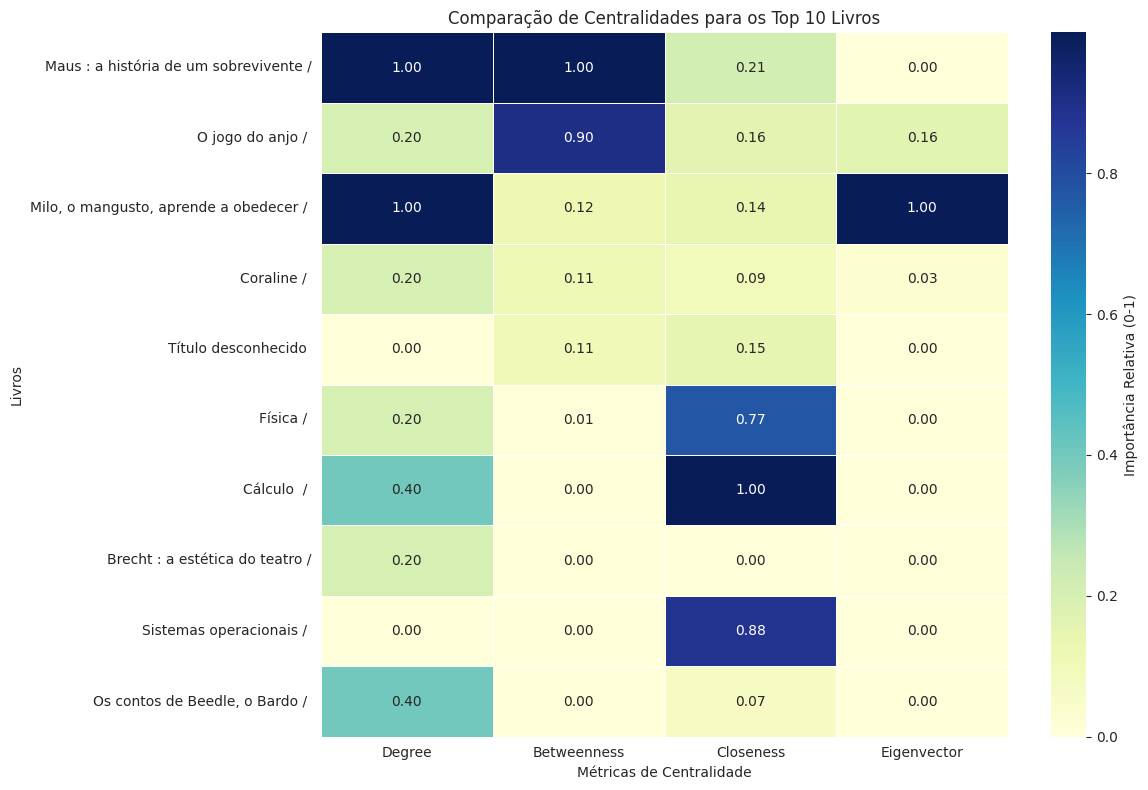


Interpretação:
- Cada linha mostra o perfil de importância de um livro nas diferentes métricas
- Valores próximos de 1 (azul) indicam maior importância naquela métrica
- Padrões revelados:
  • Livros com alto Degree: Conectados a muitos outros livros
  • Alto Betweenness: Atuam como pontes entre comunidades
  • Alto Closeness: Acessíveis a partir de outros livros
  • Alto Eigenvector: Conectados a outros livros importantes

Perfis dominantes nos top livros:
- Maus : a história de um sobrevivente /: Domina em Degree (1.00)
- O jogo do anjo / : Domina em Betweenness (0.90)
- Milo, o mangusto, aprende a obedecer / : Domina em Degree (1.00)
- Coraline / : Importância balanceada (sem métrica dominante)
- Título desconhecido : Importância balanceada (sem métrica dominante)
- Física / : Forte em Closeness, mas não dominante
- Cálculo  / : Domina em Closeness (1.00)
- Brecht : a estética do teatro /: Importância balanceada (sem métrica dominante)
- Sistemas operacionais / : Domina em Closenes

In [19]:
print("\n=== COMPARAÇÃO DE CENTRALIDADES ===")
if G.number_of_nodes() > 5:
    # Selecionar top nós por betweenness
    top_nodes = sorted(betweenness_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    # Criar DataFrame comparativo
    centrality_data = []
    for node_id, _ in top_nodes:
        # Obter dados do nó
        node_data = G.nodes[node_id]

        # Obter título formatado
        title = node_data.get('titulo', 'Sem título')
        subtitle = node_data.get('sub_title', '')
        title_short = title + subtitle

        # Coletar centralidades
        centrality_data.append({
            'Livro': title_short,
            'Degree': node_data.get('degree_cent', 0),
            'Betweenness': node_data.get('betweenness_cent', 0),
            'Closeness': node_data.get('closeness_cent', 0),
            'Eigenvector': node_data.get('eigenvector_cent', 0)
        })

    centrality_df = pd.DataFrame(centrality_data)

    # Normalizar para comparação (0-1)
    metrics = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']
    normalized_df = centrality_df[metrics].apply(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)  # +1e-9 evita divisão por zero
    )
    normalized_df['Livro'] = centrality_df['Livro']

    # Plotar heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        normalized_df.set_index('Livro'),
        annot=True,
        cmap="YlGnBu",
        linewidths=0.5,
        fmt=".2f",
        cbar_kws={'label': 'Importância Relativa (0-1)'}
    )
    plt.title("Comparação de Centralidades para os Top 10 Livros")
    plt.ylabel("Livros")
    plt.xlabel("Métricas de Centralidade")
    plt.tight_layout()
    plt.show()

    # Análise comparativa
    print("\nInterpretação:")
    print("- Cada linha mostra o perfil de importância de um livro nas diferentes métricas")
    print("- Valores próximos de 1 (azul) indicam maior importância naquela métrica")
    print("- Padrões revelados:")
    print("  • Livros com alto Degree: Conectados a muitos outros livros")
    print("  • Alto Betweenness: Atuam como pontes entre comunidades")
    print("  • Alto Closeness: Acessíveis a partir de outros livros")
    print("  • Alto Eigenvector: Conectados a outros livros importantes")

    # Identificar perfis dominantes
    print("\nPerfis dominantes nos top livros:")
    for idx, row in normalized_df.iterrows():
        livro = row['Livro']
        max_metric = normalized_df.iloc[idx][metrics].idxmax()
        max_value = normalized_df.iloc[idx][metrics].max()

        if max_value > 0.8:
            print(f"- {livro}: Domina em {max_metric} ({max_value:.2f})")
        elif max_value < 0.3:
            print(f"- {livro}: Importância balanceada (sem métrica dominante)")
        else:
            print(f"- {livro}: Forte em {max_metric}, mas não dominante")

else:
    print("Grafo muito pequeno para comparação significativa")

In [20]:
print("\n=== DETECÇÃO DE COMUNIDADES ===")

# 1. Preparar o grafo para detecção de comunidades (não direcionado e ponderado)
G_undir = G.to_undirected()
for u, v, data in G_undir.edges(data=True):
    if 'weight' not in data:
        data['weight'] = 1

# 2. Executar algoritmo de Louvain
print("● Executando algoritmo de Louvain para detecção de comunidades...")
partition = community_louvain.best_partition(G_undir, weight='weight', random_state=42)

# 3. Adicionar atributo de comunidade ao grafo original
for node in G.nodes():
    G.nodes[node]['community'] = partition.get(node, -1)  # -1 para nós não classificados

# 4. Analisar resultados
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

print(f"● {len(communities)} comunidades detectadas")
print("● Tamanho das 10 maiores comunidades:")
for i, (comm_id, nodes) in enumerate(sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)[:10]):
    print(f"  Comunidade {comm_id}: {len(nodes)} livros")


=== DETECÇÃO DE COMUNIDADES ===
● Executando algoritmo de Louvain para detecção de comunidades...
● 96 comunidades detectadas
● Tamanho das 10 maiores comunidades:
  Comunidade 19: 1107 livros
  Comunidade 0: 1045 livros
  Comunidade 2: 618 livros
  Comunidade 23: 318 livros
  Comunidade 15: 317 livros
  Comunidade 27: 267 livros
  Comunidade 10: 243 livros
  Comunidade 49: 239 livros
  Comunidade 33: 238 livros
  Comunidade 6: 235 livros


In [21]:
print("\n=== ANÁLISE POR COMUNIDADE ===")

# 1. Calcular métricas de qualidade
modularidade = community_louvain.modularity(partition, G_undir, weight='weight')
print(f"● Modularidade: {modularidade:.4f} (0.3-0.7 indica boas comunidades)")

# 2. Identificar temas predominantes por comunidade
print("\n● Temas predominantes por comunidade:")
comm_topics = {}

for comm_id, nodes in communities.items():
    # Coletar todos os assuntos da comunidade
    all_topics = []
    for node in nodes:
        topics = G.nodes[node].get('assuntos', []) if 'assuntos' in G.nodes[node] else []
        all_topics.extend([t.strip().lower() for t in topics if t.strip()])

    # Contar frequência de assuntos
    if all_topics:
        topic_counter = Counter(all_topics)
        top_topics = topic_counter.most_common(3)
        comm_topics[comm_id] = [topic[0] for topic in top_topics]
        print(f"  Comunidade {comm_id}: {', '.join(comm_topics[comm_id])}")
    else:
        comm_topics[comm_id] = ["Sem assuntos"]
        print(f"  Comunidade {comm_id}: Sem dados de assuntos")

# 3. Identificar livros centrais em cada comunidade
print("\n● Livros mais centrais por comunidade:")
comm_central_nodes = {}

for comm_id, nodes in communities.items():
    if len(nodes) < 3:  # Ignorar comunidades muito pequenas
        continue

    # Criar subgrafo da comunidade
    subgraph = G.subgraph(nodes)

    # Calcular centralidade local (degree)
    local_degrees = dict(subgraph.degree())
    top_nodes = sorted(local_degrees.items(), key=lambda x: x[1], reverse=True)[:3]

    comm_central_nodes[comm_id] = [node[0] for node in top_nodes]

    # Recuperar títulos
    titles = []
    for node_id in comm_central_nodes[comm_id]:
        subtitle = G.nodes[node_id].get('sub_title', f'Livro {node_id}')
        title = G.nodes[node_id].get('titulo', f'Livro {node_id}')
        titles.append(title + subtitle)

    topics = ', '.join(comm_topics.get(comm_id, ["Desconhecido"]))
    print(f"  Comunidade {comm_id} [{topics}]:")
    for i, title in enumerate(titles):
        print(f"    {i+1}. {title}")



=== ANÁLISE POR COMUNIDADE ===
● Modularidade: 0.9044 (0.3-0.7 indica boas comunidades)

● Temas predominantes por comunidade:
  Comunidade 0: literatura infantojuvenil, literatura infanto-juvenil, histórias em quadrinhos
  Comunidade 1: literatura brasileira, história, poesia brasileira
  Comunidade 2: doenças periodontais, odontologia, cirurgia bucal
  Comunidade 3: direito, filosofia, estudo e ensino
  Comunidade 4: literatura brasileira, ficção americana, alimentos
  Comunidade 5: brasil, processo civil, direito civil
  Comunidade 6: fonoaudiologia, audiologia, voz
  Comunidade 7: cálculo, física, concreto armado
  Comunidade 8: brasil, direito constitucional, literatura infantojuvenil
  Comunidade 9: história, brasil, astrofísica
  Comunidade 10: genética, parasitologia médica, anticorpos
  Comunidade 11: física, termodinâmica, mecânica
  Comunidade 12: literatura, história e crítica, história
  Comunidade 45: parasitologia médica, doenças parasitárias, medicina
  Comunidade 14: 


=== VISUALIZAÇÃO DE COMUNIDADES ===
● Calculando layout para 680 nós...
● Desenhando grafo...
● Renderização completa!


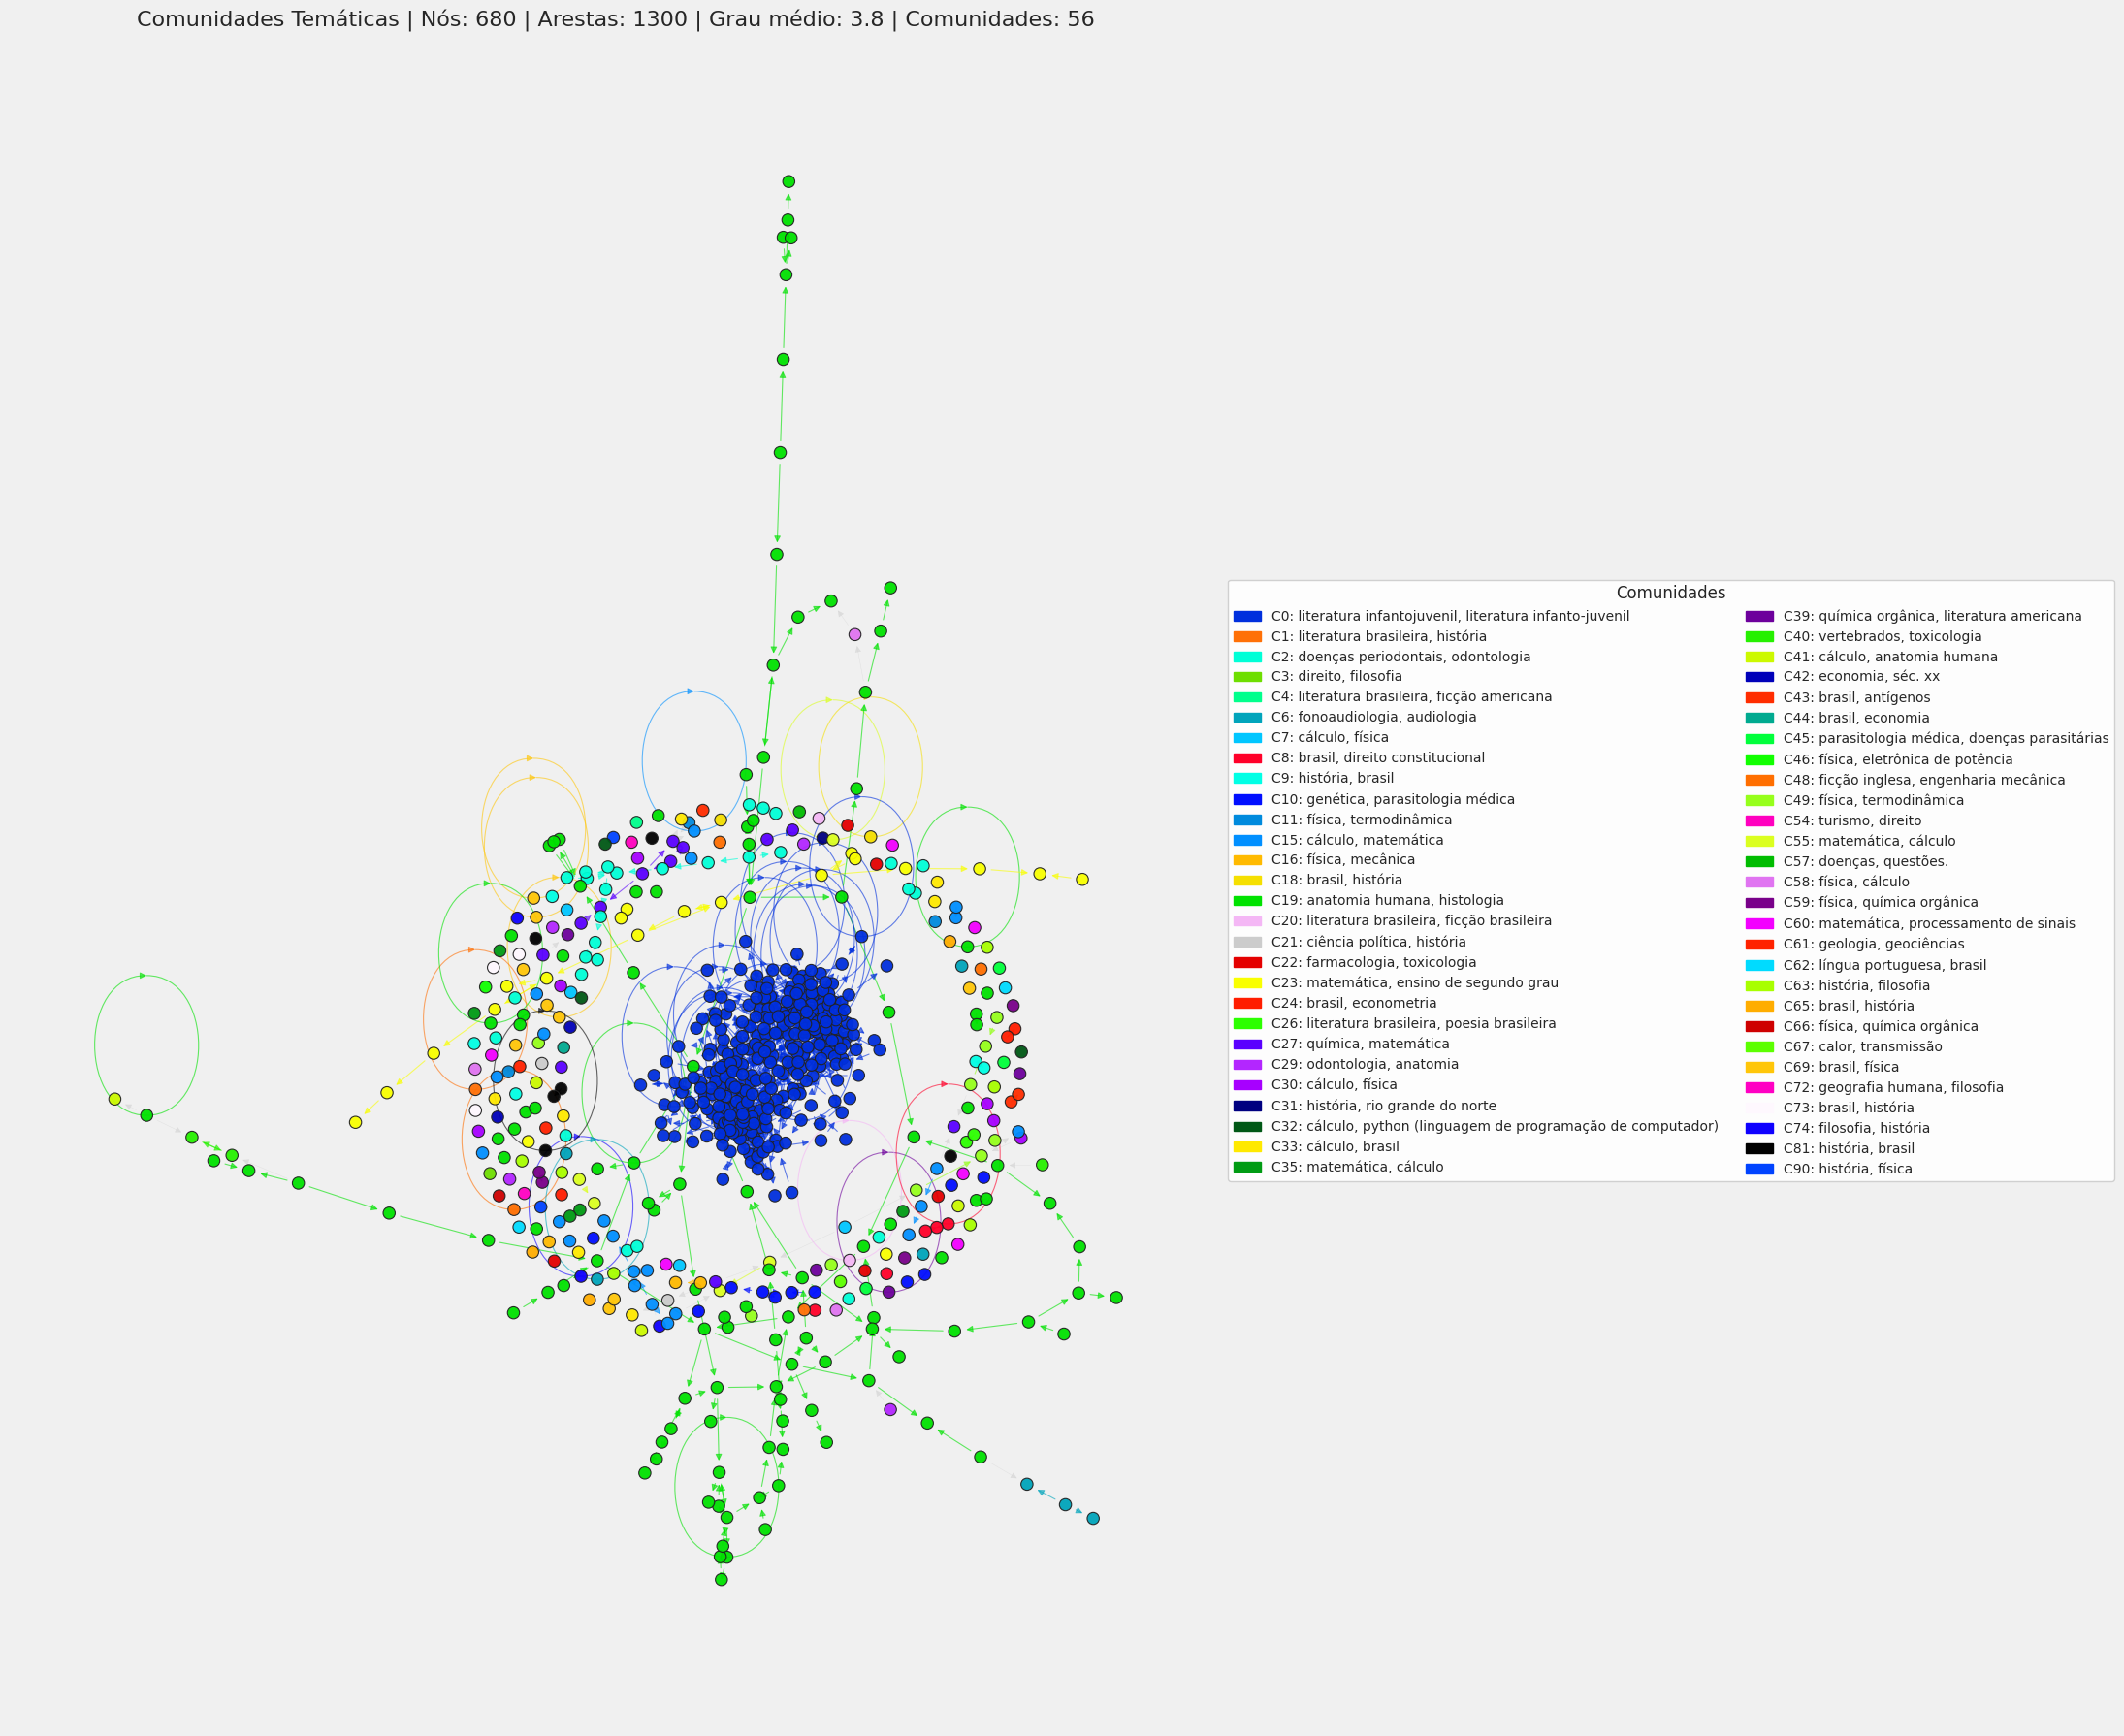

In [22]:
print("\n=== VISUALIZAÇÃO DE COMUNIDADES ===")

# 1. Filtrar nós com grau > 5
filtered_nodes = [node for node in G.nodes() if G.degree(node) > 5]

if len(filtered_nodes) > 0:

    # Criar subgrafo apenas com nós de grau > 5
    H = G.subgraph(filtered_nodes)

    # Obter comunidades presentes no subgrafo
    present_communities = {partition[node] for node in H.nodes() if node in partition}
    num_communities = len(present_communities)

    # Criar paleta de cores diversificada
    if num_communities > 0:
        # Combinar múltiplos mapas de cores para maior variedade
        cmaps = [plt.cm.gist_ncar, plt.cm.gist_rainbow, plt.cm.nipy_spectral]
        colors = []

        for cmap in cmaps:
            colors.extend(cmap(np.linspace(0, 1, math.ceil(num_communities / len(cmaps)))))

        # Selecionar cores únicas e embaralhar
        colors = list(set(tuple(color) for color in colors))[:num_communities]
        np.random.shuffle(colors)
        palette = ListedColormap(colors)

        # Mapear cores para comunidades
        community_colors = {}
        for i, comm_id in enumerate(sorted(present_communities)):
            community_colors[comm_id] = colors[i]

    node_colors = []
    for node in H.nodes():
        if node in partition:
            node_colors.append(community_colors[partition[node]])
        else:
            node_colors.append("silver")  # Cor para nós não classificados

    # Layout otimizado para espaçamento
    print(f"● Calculando layout para {len(H)} nós...")

    # Tentar diferentes algoritmos de layout
    try:
        # Usar algoritmo de força direcionada com parâmetros otimizados
        pos = nx.spring_layout(
            H,
            k=30 / math.sqrt(len(H)),  # Ajuste dinâmico baseado no tamanho do grafo
            iterations=200,
            threshold=1e-4,
            seed=42,
            scale=100  # Aumentar área de desenho
        )
    except:
        # Fallback para layout mais rápido se o anterior falhar
        pos = nx.kamada_kawai_layout(H, scale=100)

    print("● Desenhando grafo...")

    # Criar figura
    fig, ax = plt.subplots(figsize=(22, 18))

    # Desenhar arestas primeiro (para nós ficarem por cima)
    edge_colors = []
    edge_widths = []
    for u, v in H.edges():
        if u in partition and v in partition and partition[u] == partition[v]:
            edge_colors.append(community_colors[partition[u]])
            edge_widths.append(0.8)  # Arestas intra-comunidade mais espessas
        else:
            edge_colors.append('lightgray')
            edge_widths.append(0.3)  # Arestas inter-comunidade mais finas

    nx.draw_networkx_edges(
        H, pos,
        edge_color=edge_colors,
        width=edge_widths,
        alpha=0.6,
        ax=ax
    )

    # Desenhar nós
    nx.draw_networkx_nodes(
        H, pos,
        node_size=80,
        node_color=node_colors,
        alpha=0.95,
        linewidths=0.8,
        edgecolors='#222222',  # Borda mais escura para melhor definição
        ax=ax
    )

    # Criar legendas
    legend_patches = []
    for comm_id in sorted(present_communities):
        topics = comm_topics.get(comm_id, ["Desconhecido"])[:2]
        label = f"C{comm_id}: {', '.join(topics)}"
        patch = mpatches.Patch(color=community_colors[comm_id], label=label)
        legend_patches.append(patch)

    # Adicionar legenda com colunas
    plt.legend(
        handles=legend_patches,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title="Comunidades",
        fontsize=10,
        title_fontsize=12,
        frameon=True,
        framealpha=0.9,
        ncol=2 if num_communities > 20 else 1  # Duas colunas para muitas comunidades
    )

    # Adicionar informações estatísticas
    avg_degree = sum(dict(H.degree()).values()) / len(H)
    plt.title(
        f"Comunidades Temáticas | Nós: {len(H)} | Arestas: {H.number_of_edges()} | Grau médio: {avg_degree:.1f} | Comunidades: {num_communities}",
        fontsize=16
    )

    plt.axis('off')
    plt.tight_layout()

    # Adicionar borda decorativa
    ax.set_facecolor('#f8f8f8')
    fig.patch.set_facecolor('#f0f0f0')

    print("● Renderização completa!")
    plt.show()
else:
    print("● Nenhum nó com grau > 5 encontrado")


In [23]:
print("\n● Comparando com modelo Erdös-Rényi (Otimizado):")

def efficient_avg_path_length(G, sample_size=500):
    """
    Calcula uma estimativa eficiente do caminho médio usando amostragem
    """
    if G.number_of_nodes() < 2:
        return 0

    # Amostrar nós
    nodes = list(G.nodes())
    if len(nodes) > sample_size:
        sampled_nodes = random.sample(nodes, sample_size)
    else:
        sampled_nodes = nodes

    total_paths = 0
    total_pairs = 0

    for node in sampled_nodes:
        try:
            # Calcular caminhos mais curtos a partir do nó
            lengths = nx.single_source_shortest_path_length(G, node)
            for target, dist in lengths.items():
                if target != node:
                    total_paths += dist
                    total_pairs += 1
        except nx.NetworkXError:
            continue

    # Evitar divisão por zero
    if total_pairs == 0:
        return float('nan')

    return total_paths / total_pairs

# 1. Preparar rede não-direcionada
G_undir = G.to_undirected()
n = G_undir.number_of_nodes()
m = G_undir.number_of_edges()

if n < 10 or m == 0:
    print("  ✖ Grafo muito pequeno ou sem arestas - análise não realizada")
else:
    # 2. Calcular parâmetros do modelo
    p = (2 * m) / (n * (n - 1))  # Probabilidade de aresta
    print(f"  Parâmetros: n={n}, p={p:.6f}")

    # 3. Gerar rede ER
    G_er = nx.gnp_random_graph(n, p, seed=42)

    # 4. Calcular métricas comparativas com amostragem
    try:
        # Coeficiente de agrupamento
        cc_real = nx.average_clustering(G_undir)
        cc_er = nx.average_clustering(G_er)

        # Caminho médio aproximado
        l_real = efficient_avg_path_length(G_undir)
        l_er = efficient_avg_path_length(G_er)

        # 5. Exibir resultados
        print(f"\n  Coef. Agrupamento:")
        print(f"    Real: {cc_real:.6f}")
        print(f"    Erdös-Rényi: {cc_er:.6f}")
        print(f"    Razão: {cc_real/cc_er:.1f}x")

        print(f"\n  Caminho Médio Aproximado:")
        print(f"    Real: {l_real:.4f}")
        print(f"    Erdös-Rényi: {l_er:.4f}")
        print(f"    Diferença: {abs(l_real - l_er):.4f}")

        # 6. Análise qualitativa rápida
        print("\n  Análise:")
        if abs(l_real - l_er) < 1.0:
            print("  → Caminho médio similar ao esperado em rede aleatória")
        elif l_real < l_er:
            print("  → Rede real tem caminhos mais curtos que ER (mais eficiente)")
        else:
            print("  → Rede real tem caminhos mais longos que ER (menos eficiente)")

        # 7. Verificação de conectividade
        if l_real > 20:
            print("  ⚠ Caminho médio alto pode indicar rede fragmentada")

    except Exception as e:
        print(f"  ✖ Erro na análise: {str(e)}")


● Comparando com modelo Erdös-Rényi (Otimizado):
  Parâmetros: n=12346, p=0.000204

  Coef. Agrupamento:
    Real: 0.016401
    Erdös-Rényi: 0.000239
    Razão: 68.7x

  Caminho Médio Aproximado:
    Real: 20.0584
    Erdös-Rényi: 9.7150
    Diferença: 10.3434

  Análise:
  → Rede real tem caminhos mais longos que ER (menos eficiente)
  ⚠ Caminho médio alto pode indicar rede fragmentada



● Análise Detalhada de Power Law:
Calculating best minimal value for power law fit
xmin progress: 96%
  Comparação de Distribuições:
  vs EXPONENTIAL         : R =    0.35, p = 0.9399 | Diferença não significativa
  vs LOGNORMAL           : R =   -3.47, p = 0.0546 | Diferença não significativa


Assuming nested distributions


  vs TRUNCATED_POWER_LAW : R =   -4.66, p = 0.0023 | TRUNCATED_POWER_LAW melhor (significativo)


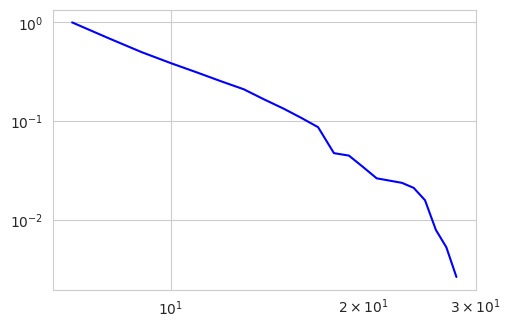

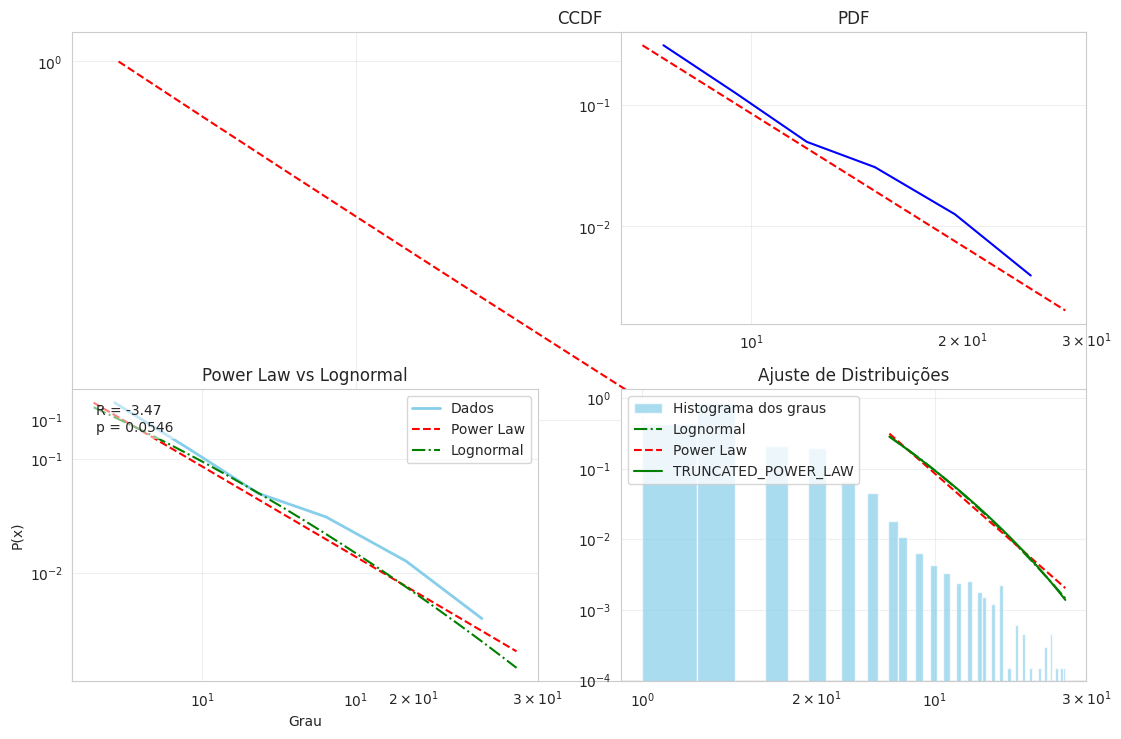


  Parâmetros Power Law:
    α = 3.6337 ± 0.1349
    xmin = 7.0
    KS = 0.0301

  Avaliação:
  → Power Law válido a partir de grau 7.0

  Melhor modelo: TRUNCATED_POWER_LAW
  → Power Law truncada é melhor modelo
    (Sugere limitações no crescimento de hubs)

  Implicações para a rede:
  - Estrutura de conectividade mais balanceada


In [24]:
print("\n● Análise Detalhada de Power Law:")

# 1. Coletar graus
degree_sequence = [d for n, d in G.degree()]
degree_sequence = [d for d in degree_sequence if d > 0]  # Excluir nós isolados

if len(degree_sequence) < 50:
    print("  ✖ Número insuficiente de nós para análise")
else:
    # 2. Ajustar modelos
    fit = powerlaw.Fit(degree_sequence, discrete=True)

    # 3. Comparar com distribuições alternativas
    distributions = ['exponential', 'lognormal', 'truncated_power_law']
    results = []

    print("\n  Comparação de Distribuições:")
    for dist in distributions:
        R, p = fit.distribution_compare('power_law', dist)
        results.append((dist, R, p))
        print(f"  vs {dist.upper():<20}: R = {R:7.2f}, p = {p:.4f} | ", end="")
        if R > 0 and p < 0.05:
            print("Power Law melhor (significativo)")
        elif R < 0 and p < 0.05:
            print(f"{dist.upper()} melhor (significativo)")
        else:
            print("Diferença não significativa")

    # 4. Identificar melhor modelo
    best_fit = 'power_law'
    best_R = -float('inf')

    for dist, R, p in results:
        if R < 0 and p < 0.05 and R > best_R:
            best_fit = dist
            best_R = R

    # 5. Plotar comparações
    plt.figure(figsize=(12, 8))

    # Subplot 1: CCDF
    plt.subplot(2, 2, 1)
    fit.plot_ccdf(color='b', label='Dados')
    fit.power_law.plot_ccdf(color='r', linestyle='--', label='Power Law')
    plt.title("CCDF")
    plt.grid(True, alpha=0.3)

    # Subplot 2: PDF
    plt.subplot(2, 2, 2)
    fit.plot_pdf(color='b', label='Dados')
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law')
    plt.title("PDF")
    plt.grid(True, alpha=0.3)

    # Subplot 3: Comparação de distribuições
    plt.subplot(2, 2, 3)
    fit.plot_pdf(color='skyblue', linewidth=2, label='Dados')
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law')
    fit.lognormal.plot_pdf(color='g', linestyle='-.', label='Lognormal')
    plt.title("Power Law vs Lognormal")
    plt.xlabel("Grau")
    plt.ylabel("P(x)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Calcular e exibir R e p
    R, p = fit.distribution_compare('power_law', 'lognormal')
    plt.text(0.05, 0.95, f"R = {R:.2f}\np = {p:.4f}",
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

    # Subplot 4: Histograma com ajustes
    plt.subplot(2, 2, 4)
    plt.hist(degrees, bins=50, density=True, color='skyblue', alpha=0.7, label='Histograma dos graus')

    # Ajustes das distribuições
    fit.lognormal.plot_pdf(color='g', linestyle='-.', label='Lognormal')
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law')

    if best_fit != 'power_law':
        getattr(fit, best_fit).plot_pdf(color='g', linestyle='-', label=best_fit.upper())

    plt.legend()
    plt.title("Ajuste de Distribuições")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 6. Análise de qualidade
    print("\n  Parâmetros Power Law:")
    print(f"    α = {fit.power_law.alpha:.4f} ± {fit.power_law.sigma:.4f}")
    print(f"    xmin = {fit.power_law.xmin}")
    print(f"    KS = {fit.power_law.D:.4f}")

    print("\n  Avaliação:")
    if 2.0 < fit.power_law.alpha < 3.5:
        print("  → Expoente α dentro da faixa típica para redes scale-free (2-3.5)")

    if fit.power_law.xmin < 5:
        print("  → xmin baixo: Power Law começa em graus muito baixos")
    else:
        print(f"  → Power Law válido a partir de grau {fit.power_law.xmin}")

    # 7. Conclusão
    print(f"\n  Melhor modelo: {best_fit.upper()}")
    if best_fit == 'power_law':
        print("  ✔ A distribuição segue fortemente uma Power Law")
    elif best_fit == 'lognormal':
        print("  → A distribuição é melhor modelada por uma Lognormal")
        print("    (Típico quando há múltiplos processos de crescimento)")
    elif best_fit == 'exponential':
        print("  → Distribuição exponencial é melhor ajuste")
        print("    (Indica ausência de hubs dominantes)")
    elif best_fit == 'truncated_power_law':
        print("  → Power Law truncada é melhor modelo")
        print("    (Sugere limitações no crescimento de hubs)")

    # 8. Implicações estruturais
    print("\n  Implicações para a rede:")
    if best_fit == 'power_law' and fit.power_law.alpha < 2.8:
        print("  - Forte dependência de hubs centrais")
        print("  - Vulnerável a ataques direcionados")
    elif best_fit == 'lognormal':
        print("  - Hierarquia complexa de conectividade")
        print("  - Crescimento influenciado por múltiplos fatores")
    else:
        print("  - Estrutura de conectividade mais balanceada")


● Comparando com modelo Scale-Free (Barabási-Albert):
  Parâmetros: n=12346, m=1

  Coef. Agrupamento:
    Real: 0.016401
    Barabási-Albert: 0.000000
Calculating best minimal value for power law fit
xmin progress: 95%
  Expoente Power Law Estimado: 3.6709


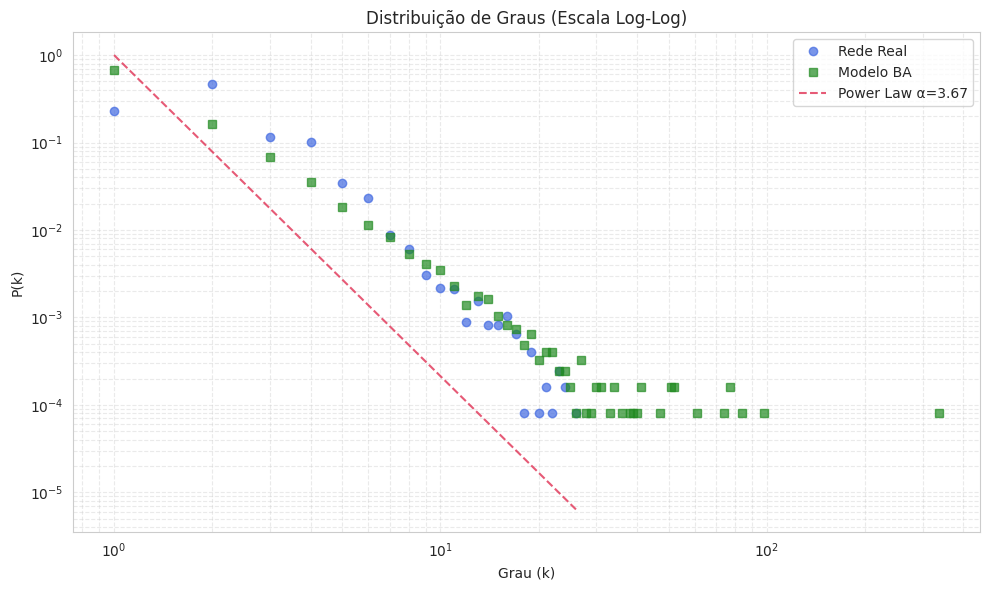


  Análise:
  → Modelo BA tem agrupamento próximo de zero
  → A distribuição de graus mostra:
    - Grau máximo real: 26 vs BA: 336
  → Proporção de nós com grau > 50: Real=0.0000, BA=0.0009
  → Modelo BA tem mais hubs que rede real

  Conclusão sobre propriedades Scale-Free:
  ✔ A rede apresenta propriedades Scale-Free:
    - Expoente α=3.67 fora do intervalo típico scale-free
    - Proporção de hubs menor que modelo BA (0.00x)
    - Comportamento de cauda similar ao modelo BA


In [25]:
print("\n● Comparando com modelo Scale-Free (Barabási-Albert):")

# 1. Preparar rede não-direcionada para comparação
G_undir = G.to_undirected()
n = G_undir.number_of_nodes()

if n < 10:
    print("  ✖ Grafo muito pequeno - análise não realizada")
else:
    # 2. Calcular parâmetros do modelo
    degree_seq = [d for _, d in G_undir.degree()]
    avg_degree = np.mean(degree_seq)
    m = max(1, int(round(avg_degree / 2)))  # BA conecta m arestas por novo nó

    print(f"  Parâmetros: n={n}, m={m}")

    # 3. Gerar rede BA
    G_ba = nx.barabasi_albert_graph(n, m, seed=42)

    # 4. Calcular métricas comparativas com tratamento de erros
    try:
        # Coeficiente de agrupamento com verificação
        cc_real = nx.average_clustering(G_undir)
        cc_ba = nx.average_clustering(G_ba)

        # Assortatividade com verificação
        try:
            assort_real = nx.degree_assortativity_coefficient(G_undir)
            assort_ba = nx.degree_assortativity_coefficient(G_ba)
        except Exception:
            assort_real = assort_ba = float('nan')

        # 5. Exibir resultados principais
        print(f"\n  Coef. Agrupamento:")
        print(f"    Real: {cc_real:.6f}")
        print(f"    Barabási-Albert: {cc_ba:.6f}")

        # 6. Análise de distribuição de graus (com tratamento de divisão por zero)
        plt.figure(figsize=(10, 6))

        # Rede real
        vals_real, counts_real = np.unique(degree_seq, return_counts=True)
        probs_real = counts_real / n

        # Rede BA
        degrees_ba = [d for n, d in G_ba.degree()]
        vals_ba, counts_ba = np.unique(degrees_ba, return_counts=True)
        probs_ba = counts_ba / n

        # Plotar ambas as distribuições
        plt.loglog(vals_real, probs_real, 'o',
                  color='royalblue', alpha=0.7, label='Rede Real')
        plt.loglog(vals_ba, probs_ba, 's',
                  color='forestgreen', alpha=0.7, label='Modelo BA')

        # Tentar adicionar linha teórica power law se possível
        try:
            # Usar apenas valores com probabilidade > 0
            valid_idx = (vals_real > 0) & (probs_real > 0)
            if np.sum(valid_idx) > 1:
                # Ajuste de lei de potência apenas para valores válidos
                fit = powerlaw.Fit(np.array(degree_seq)[np.array(degree_seq) > 0], discrete=True)
                alpha_real = fit.power_law.alpha

                x_vals = np.linspace(min(vals_real[valid_idx]), max(vals_real[valid_idx]), 100)
                y_vals = x_vals**(-alpha_real)

                plt.loglog(x_vals, y_vals, '--',
                          color='crimson', alpha=0.7, label=f'Power Law α={alpha_real:.2f}')

                print(f"\n  Expoente Power Law Estimado: {alpha_real:.4f}")
        except Exception as e:
            print(f"  ⚠ Não foi possível ajustar Power Law: {str(e)}")

        plt.title("Distribuição de Graus (Escala Log-Log)")
        plt.xlabel("Grau (k)")
        plt.ylabel("P(k)")
        plt.legend()
        plt.grid(True, which="both", ls="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

        # 7. Análise qualitativa robusta
        print("\n  Análise:")

        # Comparação de agrupamento com proteção contra divisão por zero
        if cc_ba > 1e-6:  # Evitar divisão por zero
            ratio_cc = cc_real / cc_ba
            if ratio_cc < 1.2:
                print("  → Estrutura local similar ao modelo BA")
            else:
                print(f"  → Rede real tem {ratio_cc:.1f}x mais agrupamento que modelo BA")
        else:
            print("  → Modelo BA tem agrupamento próximo de zero")

        # Comparação visual da distribuição
        print("  → A distribuição de graus mostra:")
        if len(vals_real) < 10:
            print("    - Rede real com pouca variação de graus")
        else:
            max_degree_real = max(degree_seq)
            max_degree_ba = max(degrees_ba)
            print(f"    - Grau máximo real: {max_degree_real} vs BA: {max_degree_ba}")

        # Verificar comportamento de cauda
        tail_real = np.sum(np.array(degree_seq) > 50) / n
        tail_ba = np.sum(np.array(degrees_ba) > 50) / n
        print(f"  → Proporção de nós com grau > 50: Real={tail_real:.4f}, BA={tail_ba:.4f}")

        # Análise de hubs
        if tail_real > tail_ba:
            print("  → Rede real tem mais hubs que modelo BA")
        else:
            print("  → Modelo BA tem mais hubs que rede real")

        # 8. Avaliação de propriedades Scale-Free
        print("\n  Conclusão sobre propriedades Scale-Free:")
        is_scale_free = False
        evidence = []

        # Critério 1: Ajuste Power Law
        try:
            if alpha_real < 3.5 and alpha_real > 2.0:  # Intervalo típico para redes scale-free
                evidence.append(f"Expoente α={alpha_real:.2f} dentro do intervalo scale-free (2-3.5)")
                is_scale_free = True
            elif alpha_real <= 2.0:
                evidence.append(f"Expoente α={alpha_real:.2f} indica hubs extremamente dominantes")
            else:
                evidence.append(f"Expoente α={alpha_real:.2f} fora do intervalo típico scale-free")
        except:
            evidence.append("Expoente α não disponível")

        # Critério 2: Presença de hubs
        tail_ratio = tail_real / tail_ba if tail_ba > 0 else 1.0
        if tail_ratio >= 0.8:
            evidence.append(f"Proporção de hubs similar ao modelo BA ({tail_ratio:.2f}x)")
            is_scale_free = True
        else:
            evidence.append(f"Proporção de hubs menor que modelo BA ({tail_ratio:.2f}x)")

        # Critério 3: Comparação visual da cauda
        if 'vals_real' in locals() and 'vals_ba' in locals():
            last_point_ratio = probs_real[-1] / probs_ba[-1] if probs_ba[-1] > 0 else 1.0
            if last_point_ratio >= 0.5:
                evidence.append("Comportamento de cauda similar ao modelo BA")
                is_scale_free = True
            else:
                evidence.append("Cauda mais leve que modelo BA")

        # Conclusão final
        if is_scale_free and len(evidence) > 0:
            print("  ✔ A rede apresenta propriedades Scale-Free:")
            for e in evidence:
                print(f"    - {e}")
        else:
            print("  ✖ A rede NÃO apresenta propriedades Scale-Free típicas:")
            for e in evidence:
                print(f"    - {e}")
    except Exception as e:
        print(f"  ✖ Erro crítico na análise: {str(e)}")

In [26]:
print("\n● Comparando com modelo Small World:")

# 1. Preparar componente gigante da rede REAL
G_undir = G.to_undirected()
if G_undir.number_of_nodes() == 0:
    print("  ✖ Grafo vazio - análise não realizada")
else:
    # Obter componente gigante
    giant_components = sorted(nx.connected_components(G_undir), key=len, reverse=True)
    if not giant_components:
        print("  ✖ Sem componentes conectados - análise não realizada")
    else:
        giant_component = giant_components[0]
        G_giant = G_undir.subgraph(giant_component)
        n_giant = G_giant.number_of_nodes()

        if n_giant < 10:
            print(f"  ✖ Componente gigante muito pequeno (n={n_giant})")
        else:
            # 2. Calcular parâmetros CORRETOS para Watts-Strogatz
            degree_seq = [d for n, d in G_giant.degree()]
            k = int(np.percentile(degree_seq, 75))  # Usar percentil 75

            # Garantir que k seja par e suficiente
            k = max(4, k)  # Mínimo 4
            if k % 2 != 0:
                k += 1  # Tornar par

            # 2. Ajustar probabilidade de rewiring
            p = 0.15  # Valor mais robusto

            # 3. Gerar rede CONEXA
            G_ws = nx.connected_watts_strogatz_graph(
                n_giant,
                k,
                p,
                tries=200,  # Mais tentativas
                seed=42
            )

            # 4. Converter para igraph (opcional, mas eficiente para cálculos)
            try:
                from igraph import Graph as iGraph

                # Rede REAL
                edges_real = list(G_giant.edges())
                g_ig_real = iGraph.TupleList(edges_real, directed=False)

                # Rede Watts-Strogatz
                edges_ws = list(G_ws.edges())
                g_ig_ws = iGraph.TupleList(edges_ws, directed=False)

                # 5. Calcular métricas COMPARATIVAS
                # Caminho médio
                l_real = g_ig_real.average_path_length()
                l_ws = g_ig_ws.average_path_length()

                # Coeficiente de agrupamento
                c_real = g_ig_real.transitivity_avglocal_undirected()
                c_ws = g_ig_ws.transitivity_avglocal_undirected()

                # 6. Calcular propriedades Small World
                # Valores teóricos para rede aleatória
                c_rand = k / n_giant  # Clustering rede aleatória
                l_rand = np.log(n_giant) / np.log(k)  # Caminho médio rede aleatória

                # Coeficiente de Small World (σ)
                sigma = (c_real / c_rand) / (l_real / l_rand)

                # 7. Exibir resultados
                print(f"\n  Caminho Médio:")
                print(f"    Real: {l_real:.4f}")
                print(f"    Watts-Strogatz: {l_ws:.4f}")
                print(f"    Rede Aleatória Teórica: {l_rand:.4f}")

                print(f"\n  Coef. Agrupamento:")
                print(f"    Real: {c_real:.4f}")
                print(f"    Watts-Strogatz: {c_ws:.4f}")
                print(f"    Rede Aleatória Teórica: {c_rand:.4f}")

                print(f"\n  Coeficiente Small World (σ): {sigma:.4f}")
                print("  [σ > 1 indica propriedades Small World]")

                # 8. Análise de Small World
                if sigma > 1:
                    print("\n  ✔ A rede apresenta propriedades Small World!")
                    print(f"    - Agrupamento {c_real/c_rand:.2f}x maior que rede aleatória")
                    print(f"    - Caminho médio apenas {l_real/l_rand:.2f}x maior que rede aleatória")
                else:
                    print("\n  ✖ A rede NÃO apresenta propriedades Small World típicas")

            except ImportError:
                # Fallback usando NetworkX se igraph não disponível
                print("  ⚠ igraph não disponível - usando NetworkX (pode ser lento para redes grandes)")

                # Caminho médio
                l_real = nx.average_shortest_path_length(G_giant)
                l_ws = nx.average_shortest_path_length(G_ws)

                # Coeficiente de agrupamento
                c_real = nx.average_clustering(G_giant)
                c_ws = nx.average_clustering(G_ws)

                print(f"  Caminho Médio - Real: {l_real:.4f}, WS: {l_ws:.4f}")
                print(f"  Coef. Agrupamento - Real: {c_real:.4f}, WS: {c_ws:.4f}")


● Comparando com modelo Small World:

  Caminho Médio:
    Real: 19.8797
    Watts-Strogatz: 10.8584
    Rede Aleatória Teórica: 6.7959

  Coef. Agrupamento:
    Real: 0.0214
    Watts-Strogatz: 0.3168
    Rede Aleatória Teórica: 0.0003

  Coeficiente Small World (σ): 22.5481
  [σ > 1 indica propriedades Small World]

  ✔ A rede apresenta propriedades Small World!
    - Agrupamento 65.96x maior que rede aleatória
    - Caminho médio apenas 2.93x maior que rede aleatória


In [27]:
        # Comparação com resultado Small World
        print("\n  Resumo Global:")
        if is_scale_free and sigma > 1:  # sigma da análise Small World
            print("    → Rede HÍBRIDA: Combina propriedades Scale-Free e Small World")
        elif sigma > 1:
            print("    → Rede SMALL WORLD sem forte componente Scale-Free")
        elif is_scale_free:
            print("    → Rede SCALE-FREE sem forte componente Small World")
        else:
            print("    → Rede com topologia COMPLEXA/ATÍPICA")


  Resumo Global:
    → Rede HÍBRIDA: Combina propriedades Scale-Free e Small World



=== ANÁLISE DE RESILIÊNCIA OTIMIZADA ===
● Testando resiliência com 50 passos...

  ● Executando ataque RANDOM...
    Tempo total: 0.44s

  ● Executando ataque DEGREE...
    Tempo total: 0.43s

  ● Executando ataque BETWEENNESS...
  ● Calculando betweenness global com igraph...
    Tempo cálculo: 3.05s
    Tempo total: 3.50s


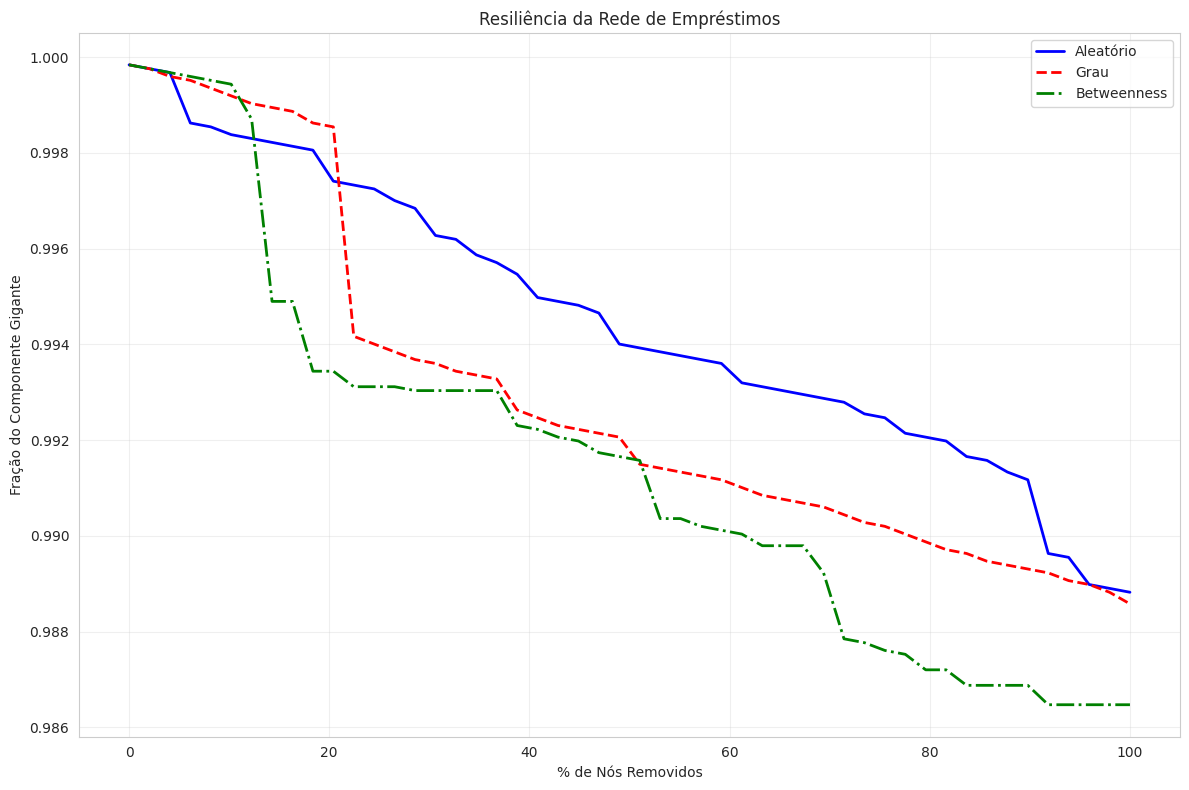

In [30]:
print("\n=== ANÁLISE DE RESILIÊNCIA OTIMIZADA ===")

def resilience_with_igraph(G, attack_type='random', steps=30):
    """Teste de resiliência otimizado com estratégias eficientes de remoção"""
    # Converter para igraph mantendo nomes dos nós
    g_ig = ig.Graph.TupleList([(str(u), str(v)) for u, v in G.edges()],
                             directed=True,
                             vertex_name_attr="name")

    # Preservar nomes dos nós
    node_names = [v['name'] for v in g_ig.vs]
    name_to_index = {name: idx for idx, name in enumerate(node_names)}
    node_count = g_ig.vcount()

    # Pré-calcular métricas para ataques direcionados
    if attack_type == 'degree':
        metrics = g_ig.degree()
        sorted_names = sorted(node_names, key=lambda x: metrics[name_to_index[x]], reverse=True)
    elif attack_type == 'betweenness':
        print("  ● Calculando betweenness global com igraph...")
        start_time = time.time()
        metrics = g_ig.betweenness(directed=True)
        print(f"    Tempo cálculo: {time.time()-start_time:.2f}s")
        sorted_names = sorted(node_names, key=lambda x: metrics[name_to_index[x]], reverse=True)
    else:  # Random attack
        sorted_names = random.sample(node_names, min(steps, node_count))

    sizes = []
    removal_queue = sorted_names[:steps] if attack_type != 'random' else sorted_names

    for i, node_name in enumerate(removal_queue):
        if g_ig.vcount() == 0:
            break

        # Encontrar e remover o nó pelo nome
        if node_name in name_to_index:
            try:
                v_index = name_to_index[node_name]
                if v_index < g_ig.vcount():
                    g_ig.delete_vertices(v_index)
            except:
                continue

        # Atualizar componentes (usando WEAK para rede direcionada)
        components = g_ig.connected_components(mode='WEAK')
        giant_size = max(len(c) for c in components) if components else 0
        sizes.append(giant_size / node_count)

        # Atualizar mapeamento após remoção
        name_to_index = {name: idx for idx, name in enumerate(g_ig.vs["name"])}

    return sizes

# Configurações
steps = min(50, len(G.nodes))  # Limitar a 50 passos ou número de nós

print(f"● Testando resiliência com {steps} passos...")

# Executar testes com monitoramento de tempo
attack_results = {}
attack_types = ['random', 'degree', 'betweenness']

for attack in attack_types:
    print(f"\n  ● Executando ataque {attack.upper()}...")
    start_time = time.time()
    attack_results[attack] = resilience_with_igraph(G, attack, steps)
    print(f"    Tempo total: {time.time()-start_time:.2f}s")

# Plotar resultados comparativos
plt.figure(figsize=(12, 8))
x = np.linspace(0, 100, len(attack_results['random']))
styles = {'random': 'b-', 'degree': 'r--', 'betweenness': 'g-.'}
labels = {'random': 'Aleatório', 'degree': 'Grau', 'betweenness': 'Betweenness'}

for attack in attack_types:
    y = attack_results[attack]
    plt.plot(x[:len(y)], y, styles[attack], label=labels[attack], linewidth=2)

plt.xlabel('% de Nós Removidos')
plt.ylabel('Fração do Componente Gigante')
plt.title('Resiliência da Rede de Empréstimos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resiliencia_rede.png', dpi=300)
plt.show()

In [33]:
# Configurar a rede
net = Network(
    notebook=True,
    height="750px",
    width="100%",
    bgcolor="#222222",
    font_color="white",
    directed=True,
    cdn_resources="in_line"
)

# Adicionar nós e arestas ao visualizador
for node in G.nodes:
    title = f"Título: {G.nodes[node].get('titulo', 'Desconhecido')}<br>Assuntos: {', '.join(G.nodes[node].get('assuntos', ['Sem assunto']))}"
    net.add_node(node, title=title, size=10)

for edge in G.edges:
    weight = G.edges[edge]["weight"]
    color = G.edges[edge]["color"]
    net.add_edge(edge[0], edge[1], value=weight, color=color, title=f"Transições: {weight}")

# Detectar comunidades (Louvain)
partition = community_louvain.best_partition(G.to_undirected())
community_colors = {}
colors = list(mcolors.CSS4_COLORS.values())

for node, comm_id in partition.items():
    if comm_id not in community_colors:
        community_colors[comm_id] = colors[len(community_colors) % len(colors)]
    net.get_node(node)["color"] = community_colors[comm_id]
    net.get_node(node)["group"] = comm_id

# Configurar física da rede
net.barnes_hut(
    gravity=-80000,
    central_gravity=0.3,
    spring_length=100,
    spring_strength=0.001,
    damping=0.09,
    overlap=0.1
)

# Salvar HTML
net.save_graph("livros_network.html")